# Minimal Model

This notebook presents an agent-based model that simulates the propagation of a disease through a network.
It demonstrates how to use the [agentpy](https://agentpy.readthedocs.io) package to create and visualize networks, use the interactive module, and perform different types of sensitivity analysis. 

In [6]:
# Model design
import agentpy as ap
import networkx as nx 
import random 

# Visualization
import matplotlib.pyplot as plt 
import seaborn as sns
import IPython

## About the model

The agents of this model are people, which can be in one of the following three conditions: susceptible to the disease (S), infected (I), or recovered (R). The agents are connected to each other through a small-world network of peers. At every time-step, infected agents can infect their peers or recover from the disease based on random chance.

## Defining the model

We define a new agent type :class:`Person` by creating a subclass of :class:`Agent`.
This agent has two methods: :func:`setup` will be called automatically at the agent's creation,
and :func:`being_sick` will be called by the :func:`Model.step` function.
Three tools are used within this class:

- :attr:`Agent.p` returns the parameters of the model
- :func:`Agent.neighbors` returns a list of the agents' peers in the network
- :func:`random.random` returns a uniform random draw between 0 and 1

In [7]:
class Person(ap.Agent):
    
    def setup(self):  
        """ Initialize a new variable at agent creation. """
        self.condition = 0  # Susceptible = 0, Infected = 1, Recovered = 2
        
    def being_sick(self):
        """ Spread disease to peers in the network. """
        rng = self.model.random
        for n in self.network.neighbors(self): 
            if n.condition == 0 and self.p.infection_chance > rng.random():
                n.condition = 1  # Infect susceptible peer
        if self.p.recovery_chance > rng.random(): 
            self.condition = 2  # Recover from infection

Next, we define our model :class:`VirusModel` by creating a subclass of :class:`Model`.
The four methods of this class will be called automatically at different steps of the simulation,
as described in :ref:`overview_simulation`.

In [8]:
class VirusModel(ap.Model):
    
    def setup(self):
        """ Initialize the agents and network of the model. """
        
        # Prepare a small-world network
        graph = nx.watts_strogatz_graph(
            self.p.population, 
            self.p.number_of_neighbors, 
            self.p.network_randomness)
        
        # Create agents and network
        self.agents = ap.AgentList(self, self.p.population, Person)
        self.network = self.agents.network = ap.Network(self, graph)
        self.network.add_agents(self.agents, self.network.nodes)
        
        # Infect a random share of the population
        I0 = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(I0).condition = 1 

    def update(self):  
        """ Record variables after setup and each step. """
        
        # Record share of agents with each condition
        for i, c in enumerate(('S', 'I', 'R')):
            n_agents = len(self.agents.select(self.agents.condition == i))
            self[c] = n_agents / self.p.population 
            self.record(c)
        
        # Stop simulation if disease is gone
        if self.I == 0:
            self.stop()
        
    def step(self):   
        """ Define the models' events per simulation step. """
        
        # Call 'being_sick' for infected agents
        self.agents.select(self.agents.condition == 1).being_sick()
    
    def end(self):     
        """ Record evaluation measures at the end of the simulation. """
        
        # Record final evaluation measures
        self.report('Total share infected', self.I + self.R) 
        self.report('Peak share infected', max(self.log['I']))

## Running a simulation

To run our model, we define a dictionary with our parameters. 
We then create a new instance of our model, passing the parameters as an argument, 
and use the method :func:`Model.run` to perform the simulation and return it's output. 

In [9]:
parameters = {  
    'population': 1000,
    'infection_chance': 0.3,
    'recovery_chance': 0.1,
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': 0.5   
}

model = VirusModel(parameters)
results = model.run() 

Completed: 115 steps
Run time: 0:00:00.057112
Simulation finished


## Analyzing results

The simulation returns a :class:`DataDict` of recorded data with dataframes:

In [10]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 6 keys
'variables': 
    'VirusModel': DataFrame with 3 variables and 116 rows
'reporters': DataFrame with 3 variables and 1 row
}

To visualize the evolution of our variables over time, we create a plot function.

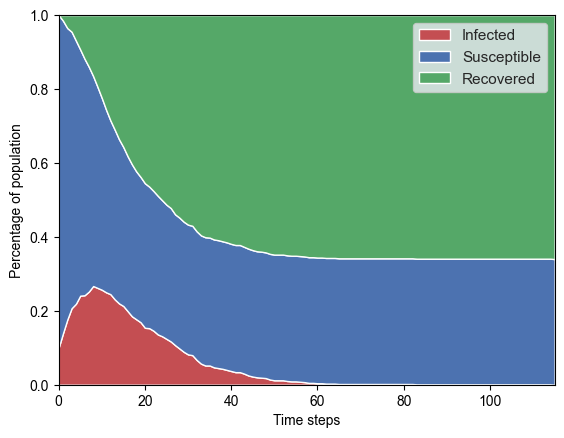

In [11]:
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """
    x = data.index.get_level_values('t')
    y = [data[var] for var in ['I', 'S', 'R']]
    
    sns.set()
    ax.stackplot(x, y, labels=['Infected', 'Susceptible', 'Recovered'],
                 colors = ['r', 'b', 'g'])    
    
    ax.legend()
    ax.set_xlim(0, max(1, len(x)-1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

## Creating an animation

We can also animate the model's dynamics as follows.
The function :func:`animation_plot` takes a model instance 
and displays the previous stackplot together with a network graph. 
The function :func:`animate` will call this plot
function for every time-step and return an :class:`matplotlib.animation.Animation`.

In [12]:
def animation_plot(m, axs):
    ax1, ax2 = axs
    ax1.set_title("Virus spread")
    ax2.set_title(f"Share infected: {m.I}")
    
    # Plot stackplot on first axis
    virus_stackplot(m.output.variables.VirusModel, ax1)
    
    # Plot network on second axis
    color_dict = {0:'b', 1:'r', 2:'g'}
    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(m.network.graph, node_color=colors, 
                     node_size=50, ax=ax2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4)) # Prepare figure 
parameters['population'] = 50 # Lower population for better visibility 
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

Using Jupyter, we can display this animation directly in our notebook.

In [15]:
IPython.display.HTML(animation.to_jshtml()) 

## Multi-run experiment

To explore the effect of different parameter values, 
we use the classes :class:`Sample`, :class:`Range`, and :class:`IntRange`
to create a sample of different parameter combinations.

In [16]:
parameters = {
    'population': ap.IntRange(100, 1000),
    'infection_chance': ap.Range(0.1, 1.),
    'recovery_chance': ap.Range(0.1, 1.),
    'initial_infection_share': 0.1,
    'number_of_neighbors': 2,
    'network_randomness': ap.Range(0., 1.)
}

sample = ap.Sample(
    parameters, 
    n=128, 
    method='saltelli', 
    calc_second_order=False
)

We then create an :class:`Experiment` that takes a model and sample as input.
:func:`Experiment.run` runs our model repeatedly over the whole sample 
with ten random iterations per parameter combination.

In [17]:
exp = ap.Experiment(VirusModel, sample, iterations=10)
results = exp.run()

Scheduled runs: 7680
Completed: 7680, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:01:38.289843


Optionally, we can save and load our results as follows:

In [18]:
results.save()

Data saved to ap_output/VirusModel_1


In [19]:
results = ap.DataDict.load('VirusModel')

Loading from directory ap_output/VirusModel_1/
Loading parameters_sample.csv - Successful
Loading parameters_constants.json - Successful
Loading reporters.csv - Successful
Loading info.json - Successful
Loading parameters_log.json - Successful


The measures in our :class:`DataDict` now hold one row for each simulation run.

In [20]:
results

DataDict {
'parameters': 
    'sample': DataFrame with 4 variables and 768 rows
    'constants': Dictionary with 2 keys
    'log': Dictionary with 5 keys
'reporters': DataFrame with 3 variables and 7680 rows
'info': Dictionary with 12 keys
}

We can use standard functions of the pandas library like 
:func:`pandas.DataFrame.hist` to look at summary statistics.

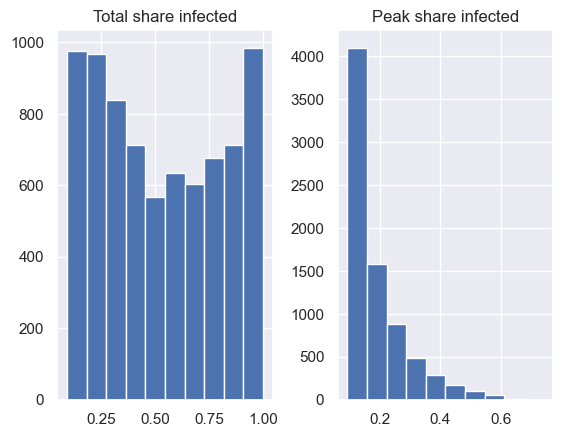

In [21]:
results.reporters.hist();

## Sensitivity analysis

The function :func:`DataDict.calc_sobol` calculates `Sobol sensitivity
indices <https://salib.readthedocs.io/en/latest/api.html#sobol-sensitivity-analysis>`_ 
for the passed results and parameter ranges, using the 
`SAlib <https://salib.readthedocs.io/en/latest/basics.html>`_ package. 

In [22]:
results.calc_sobol()

/Users/uni/miniconda3/envs/ma/lib/python3.10/site-packages/agentpy/datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'parameters': 
    'sample': DataFrame with 4 variables and 768 rows
    'constants': Dictionary with 2 keys
    'log': Dictionary with 5 keys
'reporters': DataFrame with 3 variables and 7680 rows
'info': Dictionary with 12 keys
'sensitivity': 
    'sobol': DataFrame with 2 variables and 8 rows
    'sobol_conf': DataFrame with 2 variables and 8 rows
}

This adds a new category `sensitivity` to our results, which includes:

- :attr:`sobol` returns first-order sobol sensitivity indices
- :attr:`sobol_conf` returns confidence ranges for the above indices

We can use pandas to create a bar plot that visualizes these sensitivity indices.

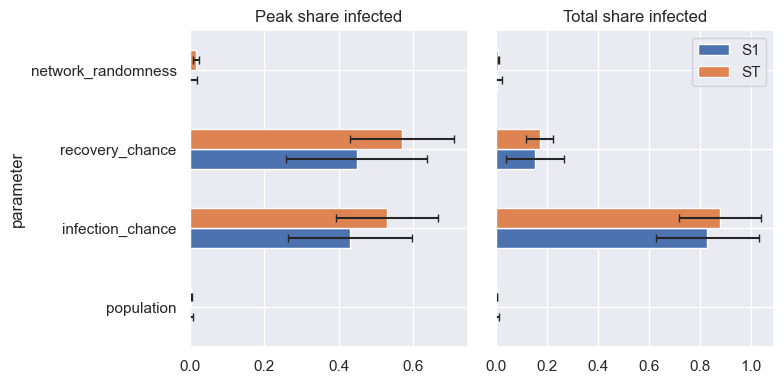

In [23]:
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """
    
    sns.set()
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    si_list = results.sensitivity.sobol.groupby(by='reporter')
    si_conf_list = results.sensitivity.sobol_conf.groupby(by='reporter')

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):
        si = si.droplevel('reporter')
        err = err.droplevel('reporter')
        si.plot.barh(xerr=err, title=key, ax=ax, capsize = 3)
        ax.set_xlim(0)
    
    axs[0].get_legend().remove()
    axs[1].set(ylabel=None, yticklabels=[]) 
    axs[1].tick_params(left=False)
    plt.tight_layout()
    
plot_sobol(results)

Alternatively, we can also display sensitivities by plotting 
average evaluation measures over our parameter variations. 

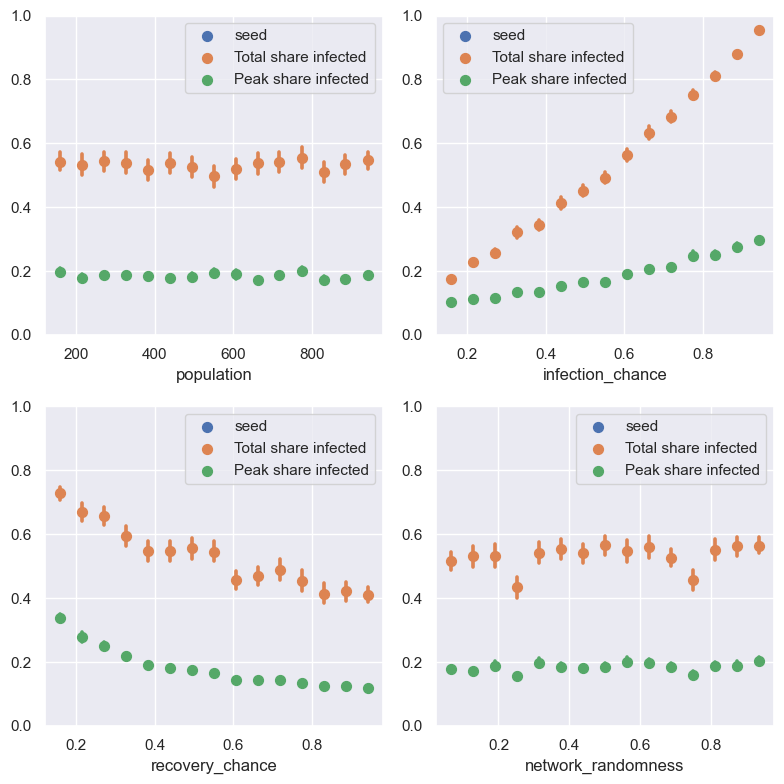

In [24]:
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """
    
    sns.set()
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
    axs = [i for j in axs for i in j] # Flatten list
    
    data = results.arrange_reporters().astype('float')
    params = results.parameters.sample.keys() 
    
    for x, ax in zip(params, axs):
        for y in results.reporters.columns:
            sns.regplot(x=x, y=y, data=data, ax=ax, ci=99, 
                        x_bins=15, fit_reg=False, label=y)  
        ax.set_ylim(0,1)
        ax.set_ylabel('')
        ax.legend()
        
    plt.tight_layout()

plot_sensitivity(results)